<a href="https://colab.research.google.com/github/ktgiahieu/BinPickingSimulation/blob/master/%5Baverage_scores_across_reviews%5D_ICLR_predicted_probability_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

# !cp /content/gdrive/My\ Drive/Dataset/kaggle.json .
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/gdrive


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import json
import glob
import numpy as np
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
import pandas as pd

# SCORES ARE AVERAGED ACROSS REVIEWS FOR EACH PAPER

In [25]:
def get_scores(conference = 'ICLR2022'):

    correctnesses = []
    technical_novelty_and_significances = []
    empirical_novelty_and_significances = []
    recommendations = []
    confidences = []
    accept_binaries = []
    for file_name in glob.glob(f"/content/gdrive/MyDrive/UPSaclay/LLMs/openreview/{conference}/reviews/*.json"):
        with open(file_name, 'r') as f:
            parsed_reviews = json.load(f)


        inv_count = -1
        while 'decision' not in parsed_reviews[inv_count]['content']:
            inv_count -=1
        accept_binary = 'accept' in parsed_reviews[inv_count]['content']['decision'].lower()
        if not accept_binary and 'reject' not in parsed_reviews[inv_count]['content']['decision'].lower():
            print(parsed_reviews[inv_count]['content']['decision'].lower())
        

        local_correctnesses = []
        local_technical_novelty_and_significances = []
        local_empirical_novelty_and_significances = []
        local_recommendations = []
        local_confidences = []
        for review in parsed_reviews:
            try:
                correctness = int(re.match(r"\d+", review['content']['correctness']).group(0))
                technical_novelty_and_significance = int(re.match(r"\d+", review['content']['technical_novelty_and_significance']).group(0))
                empirical_novelty_and_significance = int(re.match(r"\d+", review['content']['empirical_novelty_and_significance']).group(0))
                recommendation = int(re.match(r"\d+", review['content']['recommendation']).group(0))
                confidence = int(re.match(r"\d+", review['content']['confidence']).group(0))
                
                local_correctnesses.append(correctness)
                local_technical_novelty_and_significances.append(technical_novelty_and_significance)
                local_empirical_novelty_and_significances.append(empirical_novelty_and_significance)
                local_recommendations.append(recommendation)
                local_confidences.append(confidence)

            except:
                continue
        if len(local_correctnesses) == 0:
            continue
        correctnesses.append(np.mean(local_correctnesses))
        technical_novelty_and_significances.append(np.mean(local_technical_novelty_and_significances))
        empirical_novelty_and_significances.append(np.mean(local_empirical_novelty_and_significances))
        recommendations.append(np.mean(local_recommendations))
        confidences.append(np.mean(local_confidences))
        accept_binaries.append(accept_binary)
    return correctnesses, technical_novelty_and_significances, empirical_novelty_and_significances, recommendations, confidences, accept_binaries

In [32]:
# Plot the histogram of the predicted probabilities
def plot_predicted_proba_hist(X, y, title, ax):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    
    # plot the histogram of the predicted probabilities, with hue is the score in the review
    Xy_test = np.concatenate([X_test, np.array(y_pred).reshape(-1,1)], axis=1)
    Xy_test = pd.DataFrame(Xy_test, columns=[title, 'prediction'])

    norm = plt.Normalize(Xy_test[title].min(), Xy_test[title].max())
    sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
    sm.set_array([])


    
    sns.histplot(data=Xy_test, x='prediction', hue=title, ax=ax, palette='Reds', bins=30)
    ax.set_title(title)
    ax.set_xlabel('Predicted probability of acceptance')
    ax.set_ylabel('Frequency')
    ax.set_xlim(0, 1)
    ax.grid(True)

    ax.get_legend().remove()
    # ax.figure.colorbar(sm)

    plt.colorbar(sm,ax=ax)

# ICLR 2022

In [26]:
correctnesses, technical_novelty_and_significances, empirical_novelty_and_significances, recommendations, confidences, accept_binaries = get_scores(conference = 'ICLR2022')

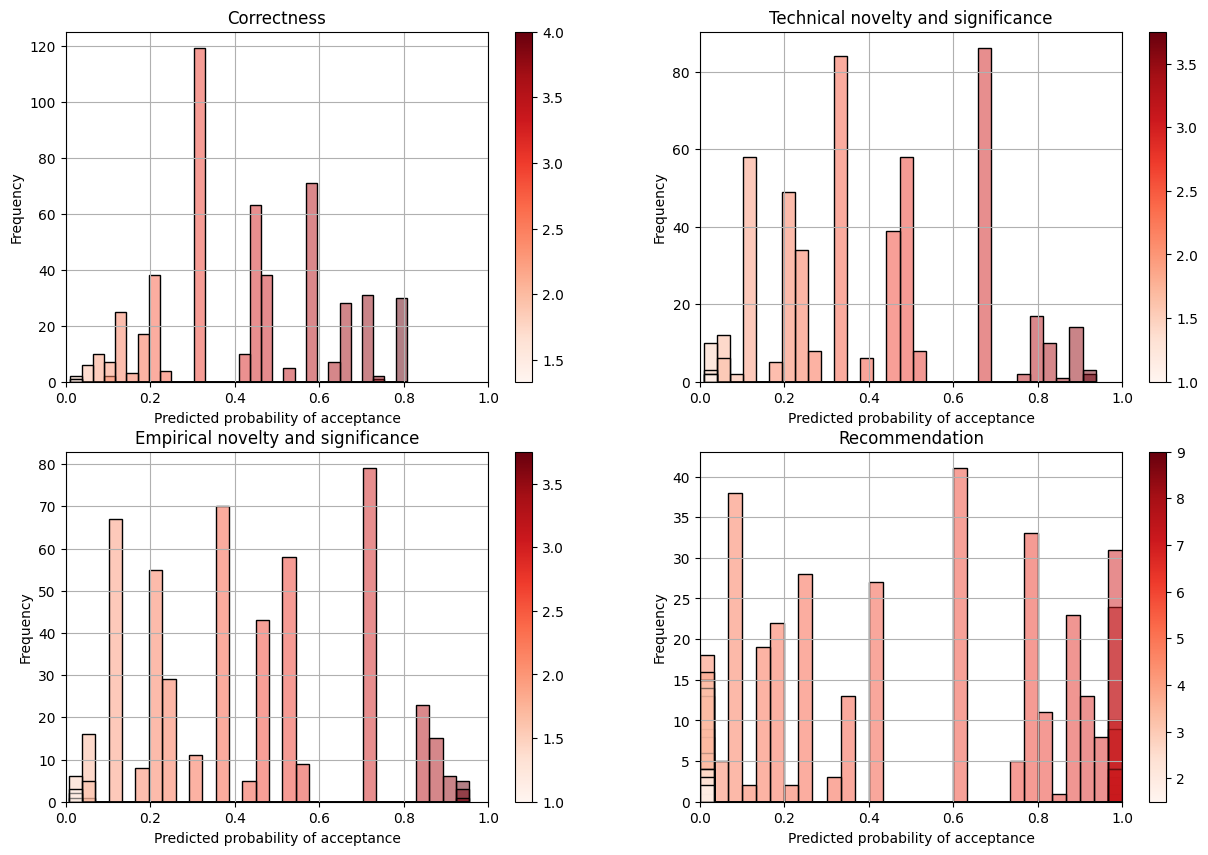

In [27]:
# Build the logistic regression model to predict the acceptance probability from the reviews score independently

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
plot_predicted_proba_hist(np.array(correctnesses).reshape(-1, 1), accept_binaries, 'Correctness', ax[0, 0])
plot_predicted_proba_hist(np.array(technical_novelty_and_significances).reshape(-1, 1), accept_binaries, 'Technical novelty and significance', ax[0, 1])
plot_predicted_proba_hist(np.array(empirical_novelty_and_significances).reshape(-1, 1), accept_binaries, 'Empirical novelty and significance', ax[1, 0])
plot_predicted_proba_hist(np.array(recommendations).reshape(-1, 1), accept_binaries, 'Recommendation', ax[1, 1])

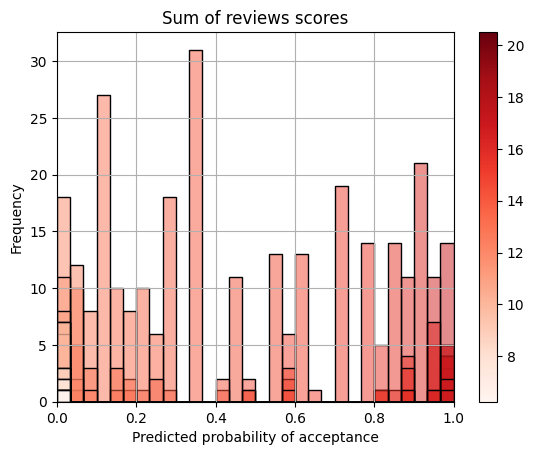

In [28]:
# Plot the histogram of the predicted probabilities using all the reviews scores for the logistic regression
fig, ax = plt.subplots(1, 1)
plot_predicted_proba_hist(np.sum([correctnesses, technical_novelty_and_significances, empirical_novelty_and_significances, recommendations], axis=0).reshape(-1,1), accept_binaries, 'Sum of reviews scores', ax)


# ICLR 2023

In [29]:
correctnesses, technical_novelty_and_significances, empirical_novelty_and_significances, recommendations, confidences, accept_binaries = get_scores(conference = 'ICLR2023')

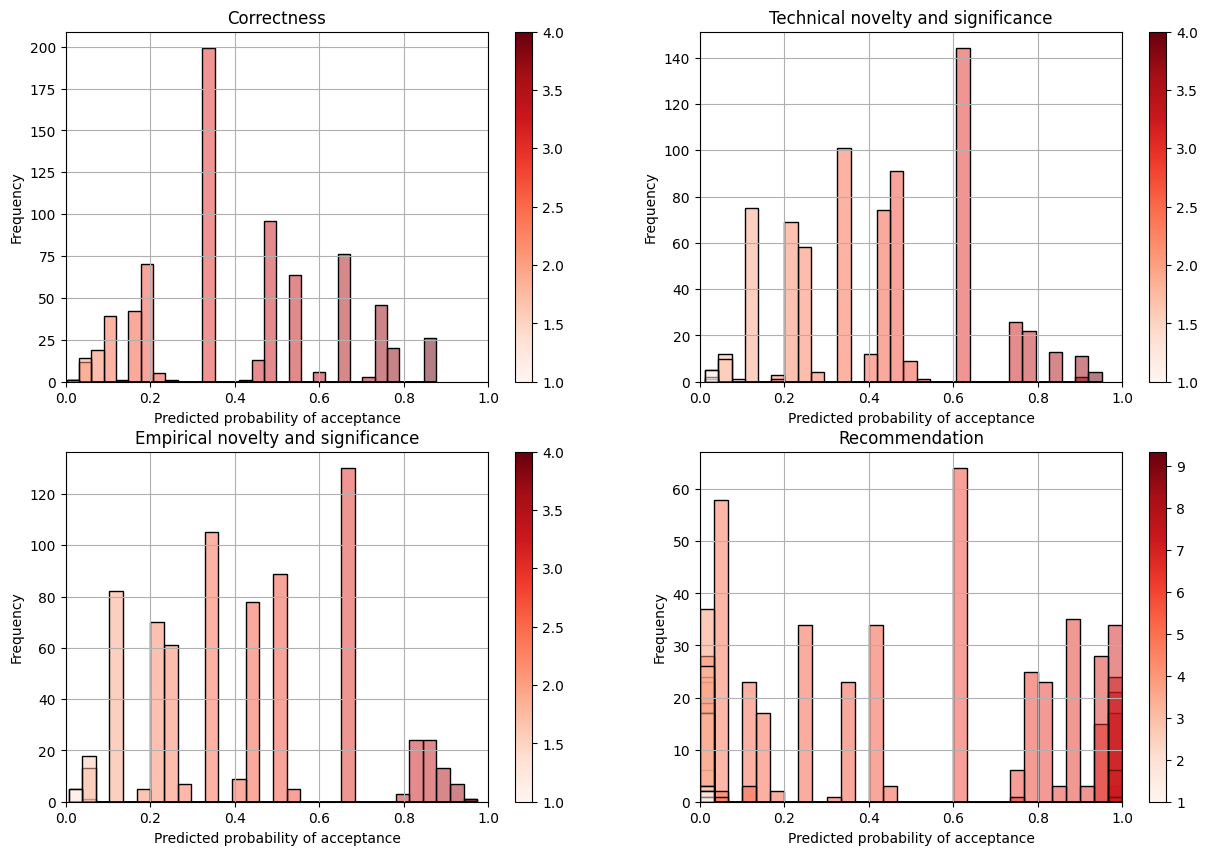

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
plot_predicted_proba_hist(np.array(correctnesses).reshape(-1, 1), accept_binaries, 'Correctness', ax[0, 0])
plot_predicted_proba_hist(np.array(technical_novelty_and_significances).reshape(-1, 1), accept_binaries, 'Technical novelty and significance', ax[0, 1])
plot_predicted_proba_hist(np.array(empirical_novelty_and_significances).reshape(-1, 1), accept_binaries, 'Empirical novelty and significance', ax[1, 0])
plot_predicted_proba_hist(np.array(recommendations).reshape(-1, 1), accept_binaries, 'Recommendation', ax[1, 1])

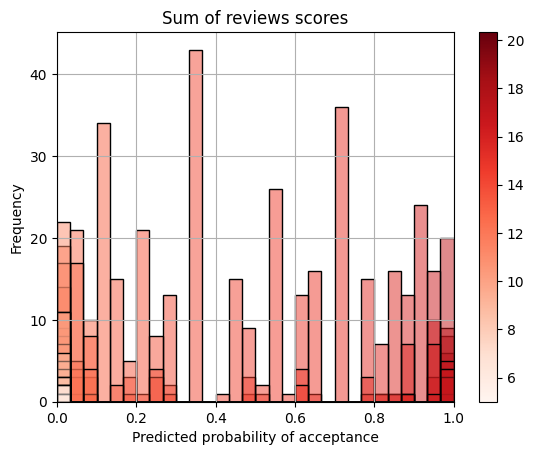

In [34]:
# Plot the histogram of the predicted probabilities using all the reviews scores for the logistic regression
fig, ax = plt.subplots(1, 1)
plot_predicted_proba_hist(np.sum([correctnesses, technical_novelty_and_significances, empirical_novelty_and_significances, recommendations], axis=0).reshape(-1,1), accept_binaries, 'Sum of reviews scores', ax)
